In [2]:
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("tunnels-ssl/probing-19-05-2024")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict["test_acc"])

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"test_acc": summary_list, "config": config_list, "name": name_list}
)

In [4]:
config_df = pd.json_normalize(runs_df["config"])
df = pd.concat([runs_df.drop(columns=["config"]), config_df], axis=1)
# df["data.datasets"] = df["data.datasets"].apply(lambda x: x[0])

In [48]:
import pandas as pd
import ast
from collections.abc import MutableMapping

# Sample structure of runs_df
# Assuming runs_df is a DataFrame with a column "config" containing the nested dictionaries


# Function to flatten nested dictionaries
def flatten(d, parent_key="", sep="."):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


# Function to parse and transform a single row
def parse_and_transform(config):
    # Parsing the string representations of the dictionaries
    data_dict = ast.literal_eval(config["data"])
    misc_dict = ast.literal_eval(config["misc"])
    model_dict = ast.literal_eval(config["model"])
    training_dict = ast.literal_eval(config["training"])

    # Combining all dictionaries into a single dictionary
    combined_dict = {
        **data_dict,
        **misc_dict,
        **model_dict,
        **training_dict,
        "task": config["task"],
        "data_task": config["data_task"],
        "num_classes": config["num_classes"],
    }

    # Flatten the combined dictionary
    flattened_dict = flatten(combined_dict)

    return flattened_dict


# Apply the function to each row in runs_df
transformed_rows = runs_df["config"].apply(parse_and_transform)
final_df = pd.DataFrame(transformed_rows.tolist())
df = pd.concat([runs_df.drop(columns=["config"]), final_df], axis=1)

In [49]:
df.columns

Index(['test_acc', 'name', 'batch_size', 'datasets',
       'exemplars.exemplar_selection', 'exemplars.num_exemplars',
       'exemplars.num_exemplars_per_class', 'extra_aug',
       'max_classes_per_dataset', 'max_examples_per_class_trn',
       'max_examples_per_class_tst', 'max_examples_per_class_val',
       'nc_first_task', 'nc_per_task', 'ne_first_task', 'num_tasks',
       'num_workers', 'stop_at_task', 'use_test_as_val', 'use_valid_only',
       'cache_first_task_model', 'cm', 'exp_name', 'gpu',
       'last_layer_analysis', 'log', 'no_cudnn_deterministic', 'results_path',
       'save_models', 'seed', 'tags', 'keep_existing_head', 'network',
       'pretrained', 'approach.kwargs.all_outputs', 'approach.name',
       'clipping', 'early_stopping.lr_factor', 'early_stopping.lr_min',
       'early_stopping.lr_patience', 'eval_on_train', 'fix_bn',
       'gridsearch_tasks', 'lr', 'multi_softmax', 'nepochs', 'no_learning',
       'optimizer.kwargs.weight_decay', 'optimizer.name',
  

In [70]:
import numpy as np
from itertools import product


conditions = df["approach.name"].str.contains("lwf")
conditions &= df["vcreg.reg_layers"].isna()
# final_df["vcreg.reg_layers"].isna()
# final_df["exemplars.num_exemplars"]

approaches = {
    "finetuning": ("finetuning", 0),
    "replay": ("finetuning", 2000),
    "ewc": ("ewc", 0),
    "lwf": ("lwf", 0),
}
regs = [True, False]

expname_results = {}
for (approach_name, num_exemplars), is_reg in product(approaches.values(), regs):
    conditions = np.ones(df.shape[0], dtype=bool)
    conditions &= df["approach.name"].str.contains(approach_name)
    conditions &= df["exemplars.num_exemplars"] == num_exemplars
    conditions &= (
        df["vcreg.reg_layers"].notna() if is_reg else df["vcreg.reg_layers"].isna()
    )
    assert df[conditions].shape[0] == 5
    real_name = approach_name if num_exemplars == 0 else "replay"
    reg_str = "reg" if is_reg else "noreg"
    key_name = f"{real_name}_{reg_str}"

    expname_results[key_name] = (
        df[conditions][["task", "test_acc"]]
        .sort_values("task")["test_acc"]
        .values.tolist()
    )

In [92]:
expname_results.keys()

dict_keys(['finetuning_reg', 'finetuning_noreg', 'replay_reg', 'replay_noreg', 'ewc_reg', 'ewc_noreg', 'lwf_reg', 'lwf_noreg'])

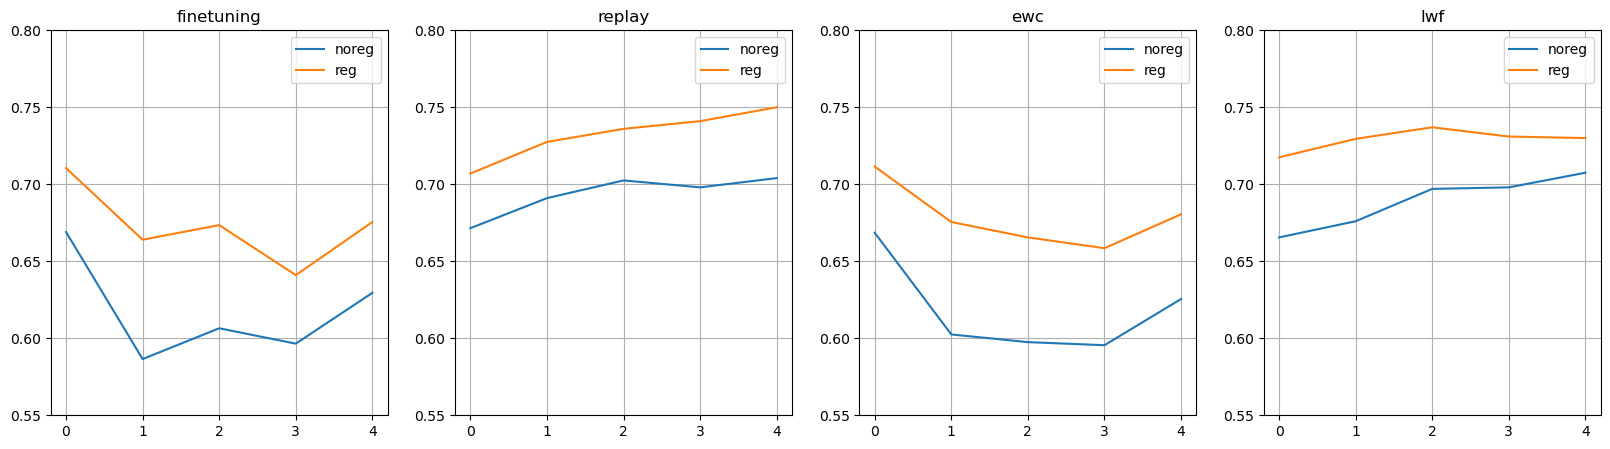

In [102]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(approaches.keys()), figsize=(20, 5))
for i, approach_name in enumerate(approaches.keys()):
    axs[i].plot(expname_results[f"{approach_name}_noreg"], label="noreg")
    axs[i].plot(expname_results[f"{approach_name}_reg"], label="reg")
    axs[i].legend()
    axs[i].grid()
    axs[i].set_ylim([0.55, 0.8])
    axs[i].set_title(approach_name)

plt.show()

'finetuning'

In [34]:
filtered_df = df[
    (df["model.network"].str.contains("resnet"))
    & (df["misc.seed"] == 0)
    & (df["data.datasets"].str.contains("imagenet"))
    & (df["training.approach.name"] == "ewc")
    & (df["data.num_tasks"] == 10)
]
filtered_df["avg_acc_tag"]

23    17.24
36    14.34
Name: avg_acc_tag, dtype: float64

In [12]:
from pathlib import Path
import pandas as pd

# Assuming df is your DataFrame
approaches = {
    "finetuning": ("finetuning", 0),
    "replay": ("finetuning", 2000),
    "ewc": ("ewc", 0),
    "lwf": ("lwf", 0),
}


# Filter the DataFrame for the common conditions
def get_table(network, seed, dataset):
    # fmt: off
    filtered_df = df[
        (df["model.network"] == network) 
        & (df["misc.seed"] == seed)
        & (df["data.datasets"] == dataset)
        ]
    # fmt: on

    # Create a function to extract the relevant data
    def extract_data(approach_name, num_exemplars, reg_layers, num_tasks):
        condition = (
            (filtered_df["training.approach.name"] == approach_name)
            & (filtered_df["data.exemplars.num_exemplars"] == num_exemplars)
            & (filtered_df["data.num_tasks"] == num_tasks)
        )

        if reg_layers == "nan":
            condition &= filtered_df["training.vcreg.reg_layers"].isna()
        else:
            condition &= filtered_df["training.vcreg.reg_layers"].notna()
        assert filtered_df[condition].shape[0] == 1
        return filtered_df[condition]["avg_acc_tag"].item()  # FIXME

    # Initialize the results list
    results = []

    # Define the parameters

    reg_layers_options = {"nan": False, "reg": True}
    num_tasks_options = [20]  # FIXME

    # Extract the data
    for num_tasks in num_tasks_options:
        for approach_name, (approach, num_exemplars) in approaches.items():
            for reg_layers, is_reg_applied in reg_layers_options.items():
                avg_acc_tag = extract_data(
                    approach, num_exemplars, reg_layers, num_tasks
                )

                results.append(
                    (
                        num_tasks,
                        approach_name,
                        is_reg_applied,
                        avg_acc_tag,
                        dataset,
                        seed,
                    )
                )

    # Create a DataFrame from the results
    result_df = pd.DataFrame(
        results,
        columns=[
            "num_tasks",
            "approach",
            "reg_layers",
            "avg_acc_tag",
            "dataset",
            "seed",
        ],
    )

    save_path = Path(f"csvs/{network}/{dataset}_s{seed}.csv")
    save_path.parent.mkdir(exist_ok=True)

    # result_df.to_csv(save_path, index=False)

    # Pivot the DataFrame to get the desired format
    # result_df = result_df.pivot_table(
    #     index=["num_tasks", "approach"],
    #     columns=["reg_layers"],
    #     values="avg_acc_tag",
    # )
    return result_df

In [13]:
import itertools


networks = ["convnext_tiny", "resnet34_skips"]
# seeds = [1, 2]
seeds = [0]
# datasets = ["cifar100_fixed", "imagenet_subset_kaggle"]

# Generate the Cartesian product
combinations = itertools.product(networks, seeds)

for network, seed in combinations:
    res = get_table(network, seed, "cifar100_fixed")

AssertionError: 

In [8]:
res

,num_tasks,approach,reg_layers,avg_acc_tag,dataset,seed
0,10,finetuning,False,17.60,imagenet_subset_kaggle,1
1,10,finetuning,True,24.58,imagenet_subset_kaggle,1
2,10,replay,False,33.36,imagenet_subset_kaggle,1
3,10,replay,True,33.86,imagenet_subset_kaggle,1
4,10,ewc,False,21.10,imagenet_subset_kaggle,1
5,10,ewc,True,34.52,imagenet_subset_kaggle,1
6,10,lwf,False,43.44,imagenet_subset_kaggle,1
7,10,lwf,True,43.26,imagenet_subset_kaggle,1
8,20,finetuning,False,7.36,imagenet_subset_kaggle,1
9,20,finetuning,True,13.20,imagenet_subset_kaggle,1


In [48]:
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("tunnels-ssl/05.16")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict["test/wavg_acc_tag"])

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"wavg_acc_tag": summary_list, "config": config_list, "name": name_list}
)

In [49]:
config_df = pd.json_normalize(runs_df["config"])
df = pd.concat([runs_df.drop(columns=["config"]), config_df], axis=1)

In [50]:
# fmt: off
filtered_df = df[
    (df["data.nc_first_task"] == 50) 
    ]
# fmt: on

In [51]:
filtered_df["reg_layers"] = filtered_df["training.vcreg.reg_layers"].notna()

/tmp/ipykernel_3473465/2652839817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["reg_layers"] = filtered_df["training.vcreg.reg_layers"].notna()


In [52]:
filtered_df[["training.approach.name", "data.exemplars.num_exemplars"]].shape

(16, 2)

In [53]:
def get_real_name(row):
    if row["data.exemplars.num_exemplars"] > 0:
        return "replay"
    return row["training.approach.name"]


# Apply the function to create the real_name column
filtered_df["real_name"] = filtered_df.apply(get_real_name, axis=1)
filtered_df["data.datasets"] = filtered_df["data.datasets"].apply(lambda x: x[0])

/tmp/ipykernel_3473465/1684185840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["real_name"] = filtered_df.apply(get_real_name, axis=1)
/tmp/ipykernel_3473465/1684185840.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["data.datasets"] = filtered_df["data.datasets"].apply(lambda x: x[0])


,wavg_acc_tag,name,data.datasets,data.exemplars.num_exemplars,data.exemplars.exemplar_selection,data.exemplars.num_exemplars_per_class,data.extra_aug,data.num_tasks,data.batch_size,data.nc_per_task,...,training.approach.kwargs.debug_loss,training.approach.kwargs.taskwise_kd,training.approach.kwargs.pretraining_epochs,training.approach.kwargs.alpha,training.approach.kwargs.fi_num_samples,training.approach.kwargs.fi_sampling_type,training.vcreg,training.optimizer.kwargs.momentum,reg_layers,real_name
1,35.79,curious-lion-16,cifar100_fixed,2000,random,0,,6,128,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,replay
2,50.79,good-serenity-15,cifar100_fixed,0,random,0,,6,128,None,...,False,False,5.0,NaN,NaN,NaN,NaN,NaN,True,lwf
5,38.76,icy-pyramid-13,cifar100_fixed,0,random,0,,6,128,None,...,NaN,NaN,NaN,0.5,-1.0,max_pred,NaN,NaN,True,ewc
6,28.29,exalted-pyramid-11,cifar100_fixed,0,random,0,,6,128,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,finetuning
9,43.58,snowy-aardvark-8,cifar100_fixed,0,random,0,,6,128,None,...,False,False,5.0,NaN,NaN,NaN,NaN,NaN,False,lwf
11,27.89,woven-glitter-6,cifar100_fixed,0,random,0,,6,128,None,...,NaN,NaN,NaN,0.5,-1.0,max_pred,NaN,NaN,False,ewc
13,29.74,solar-snowball-4,cifar100_fixed,2000,random,0,,6,128,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,replay
15,22.14,breezy-dust-2,cifar100_fixed,0,random,0,,6,128,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,finetuning


In [56]:
filtered_df[filtered_df["misc.seed"] == 2][
    ["reg_layers", "real_name", "wavg_acc_tag", "misc.seed", "data.datasets"]
].to_csv("big_task_2.csv", index=False)

In [146]:
to_dump = filtered_df[
    ["reg_layers", "real_name", "wavg_acc_tag", "misc.seed", "data.datasets"]
]
to_dump

,reg_layers,real_name,wavg_acc_tag,misc.seed,data.datasets
95,True,replay,35.87,0,c
97,True,lwf,54.09,0,c
98,True,finetuning,29.37,0,c
99,True,ewc,39.28,0,c
100,False,lwf,44.83,0,c
101,False,ewc,30.41,0,c
102,False,replay,29.15,0,c
103,False,finetuning,23.22,0,c


In [147]:
to_dump.to_csv("big_task.csv", index=False)